In [1]:
#Importation of all API's that will be used (will expand as use cases crop up that need solving)

import pandas as pd
from pandas.plotting import table
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
import scipy
from seaborn import clustermap
from scipy.stats import ttest_ind
import pprint

In [2]:
#Make a dict for all (Unique) occurances

def correlate_counts(dataframe, outside_header, inside_header):
    counts = {}
    for index, row in dataframe.iterrows():
        outer = row[outside_header]
        inner = row[inside_header]
        if outer not in counts:
            counts[outer] = {}
        if inner not in counts[outer]:
            counts[outer][inner] = 0
        counts[outer][inner] += 1

    for outer in counts.keys():
        counts[outer]["total"] = sum(counts[outer].values())



    inner_counts = {}
    for outer in counts:
        for inner in counts[outer]:
            if inner not in inner_counts:
                inner_counts[inner] = 0
            inner_counts[inner] += counts[outer][inner]

    
    return counts, inner_counts



In [3]:
#turn dict into df so combining into a three column df is possible

def counts_heatmap(counts, add_headers=False):
    outer = counts.keys()
    inners = set()
    for outer in counts.keys():
        inners.update(counts[outer].keys())
    inners.remove("total")
   
    inners_cols = sorted(inners)
    inners.add('')

    heatmap = []
    if add_headers:
        heatmap.append(sorted(inners))

    outers_rows = sorted(counts.keys())

    for outer in sorted(counts.keys()):
        new_row = []
        if add_headers:
            new_row.append(outer)
        for inner in sorted(inners)[1:]:
            new_row.append(float(counts[outer].get(inner, 0)))
        heatmap.append(new_row)

    return heatmap, inners_cols, outers_rows



In [4]:
debug = False

In [5]:
# Import Source document with only the columns that are needed for intended analysis

rawdata_MycoDB = pd.read_csv("MycoDB_version1.csv", usecols = (
["PlantFamily", "PlantSpecies", "FungalGenus", "PLANTLIFEHISTORY", "FUNGROUP"]))

rawdata_BFIBundle = pd.read_csv("bfi-source.csv", usecols = ["Fungal_host_taxa", "Bacterial_associate_taxa"])

#Test to see if imported correctly
if debug:
    print (rawdata_MycoDB)
    print (rawdata_BFIBundle)

In [6]:
#Removing columns that lack full data so that it cannot mess with future testing 
#(primarly only fungal genus infomation missing in source data)

rawdata_MycoDB_na = rawdata_MycoDB.dropna()
rawdata_BFIBundle_na = rawdata_BFIBundle.dropna()

#Test to see if removal of NaN data worked as intended
if debug:
    print (rawdata_MycoDB_na)
    print (rawdata_BFIBundle_na)

In [7]:
# Seperated MycoDB data by life histories so testing between them can occur and grpah creation simplified

filtered_rawdata_MycoDB_na_ab = rawdata_MycoDB_na[rawdata_MycoDB_na[
"PLANTLIFEHISTORY"].str.contains("annual_biennial")]
filtered_rawdata_MycoDB_na_p = rawdata_MycoDB_na[rawdata_MycoDB_na["PLANTLIFEHISTORY"].str.contains("perennial")]

# Test to see if seperation of data worked as intended
if debug:
    print (filtered_rawdata_MycoDB_na_ab)
    print (filtered_rawdata_MycoDB_na_p)

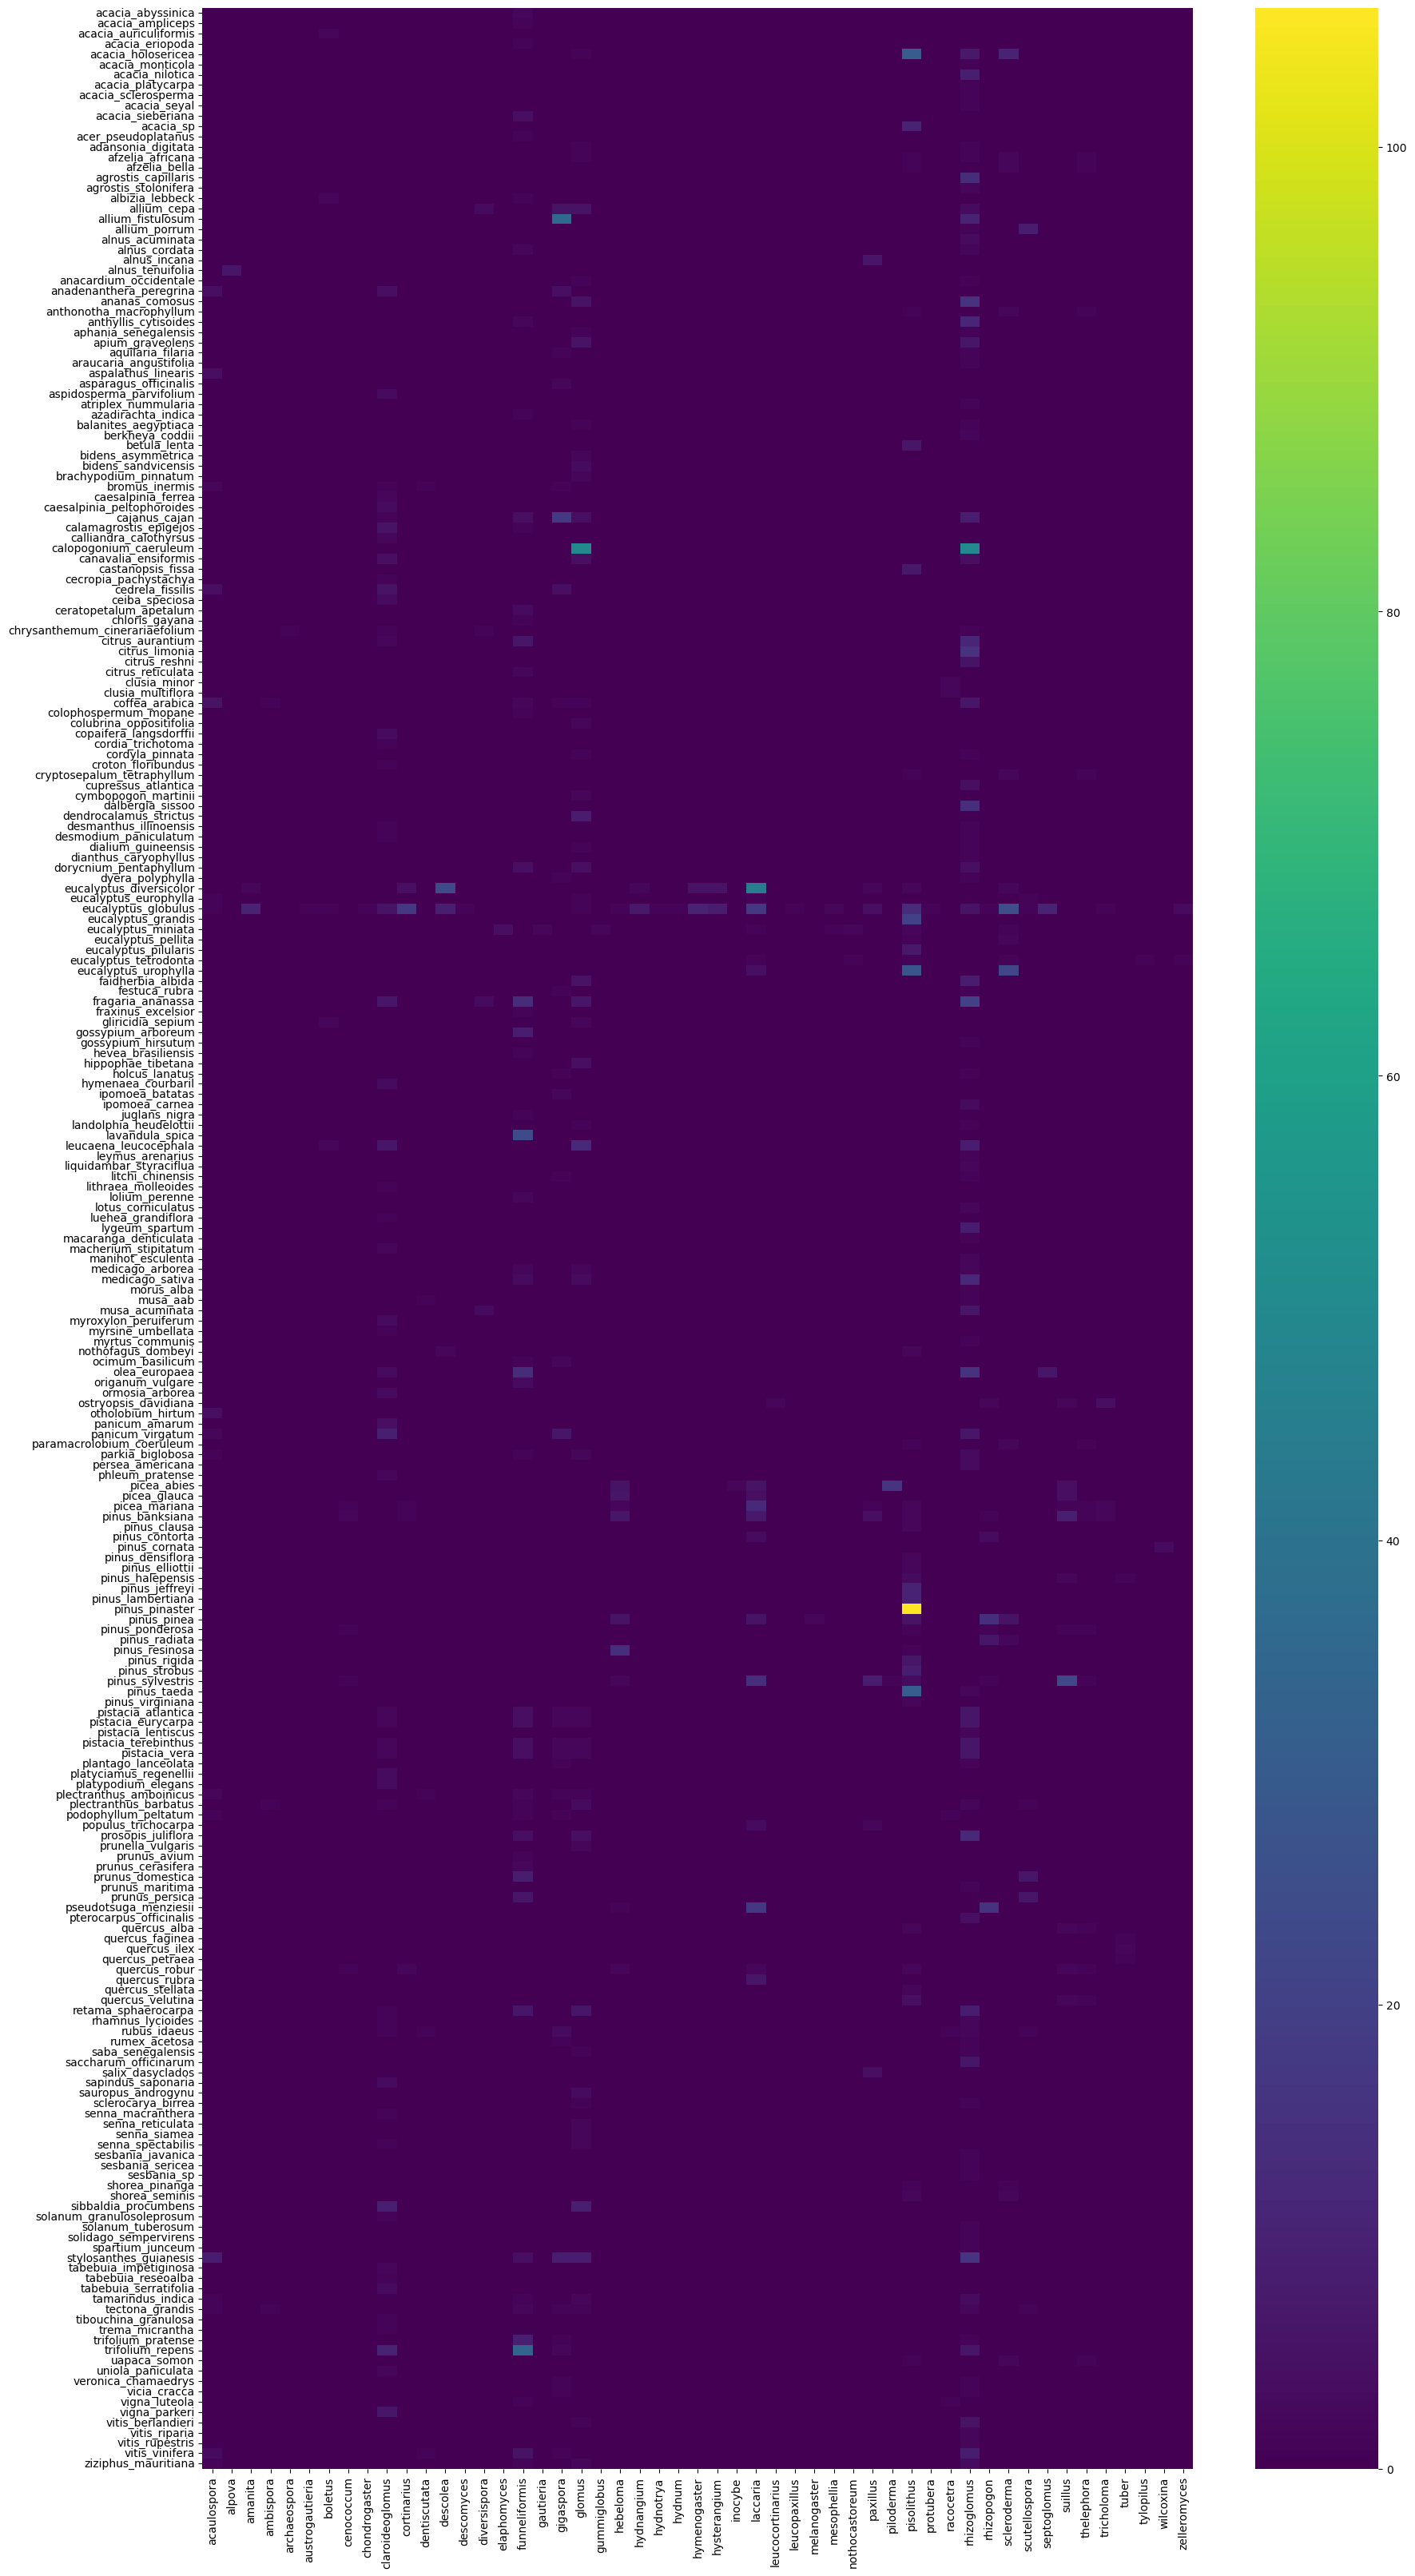

In [8]:
#Generate needed material for heatmap of occurnaces

counts_p, fungal_count_p = correlate_counts(filtered_rawdata_MycoDB_na_p, "PlantSpecies", "FungalGenus")
if debug:
    print(counts_p)
    print(fungal_count_p)

heatmap_p, fungi_cols_p, plants_rows_p = counts_heatmap(counts_p)
heatmap_p_df = pd.DataFrame(heatmap_p)

if debug:
    pprint.pprint(heatmap_p)
    print (heatmap_p_df)

fig, ax = plt.subplots(figsize=(20,40))

heatmap_p_img = sns.heatmap(heatmap_p, cmap='viridis', xticklabels=fungi_cols_p, yticklabels=plants_rows_p, ax=ax)

plt.savefig("heatmap_p_img.png", dpi=300)

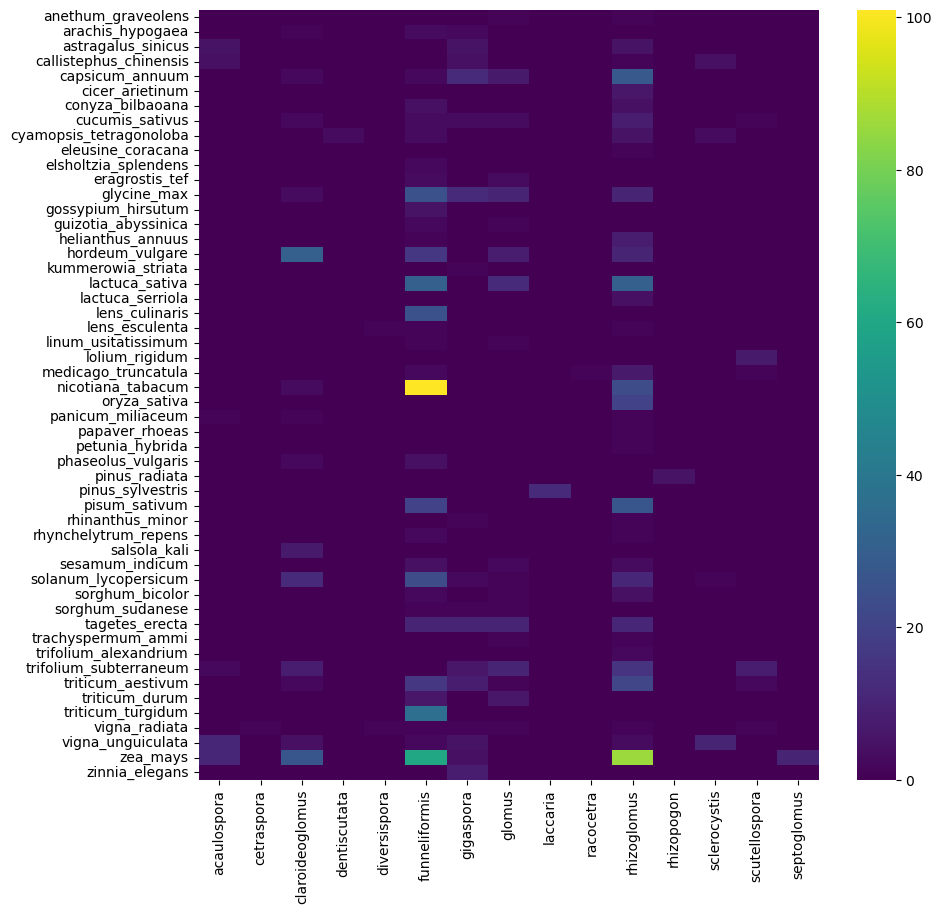

In [9]:
#Generate needed material for heatmap of occurnaces

counts_ab, fungal_count_ab = correlate_counts(filtered_rawdata_MycoDB_na_ab, "PlantSpecies", "FungalGenus")
if debug:
    print(counts_ab)
    print(fungal_count_ab)
    
heatmap_ab, fungi_cols_ab, plants_rows_ab = counts_heatmap(counts_ab)
heatmap_ab_df = pd.DataFrame(heatmap_ab)

if debug:
    pprint.pprint(heatmap_ab)
    print (heatmap_ab_df)

fig, ax = plt.subplots(figsize=(10,10))

heatmap_ab_img = sns.heatmap(heatmap_ab, cmap='viridis', xticklabels=fungi_cols_ab, yticklabels=plants_rows_ab, ax=ax)

plt.savefig("heatmap_ab_img.png", dpi=300)

In [10]:
#Generate needed material for data metric tests

heatmap_ab_la = counts_heatmap(counts_ab, add_headers=True)
heatmap_ab_la_df = pd.DataFrame(heatmap_ab_la)
heatmap_ab_la_df.to_csv('heatmap_ab_la_df.csv', sep=',', index=True, encoding='utf-8')
heatmap_ab_mergedata = pd.read_csv('heatmap_ab_la_df.csv')
MycoDB_ab_merge = heatmap_ab_mergedata.copy()

if debug: print(heatmap_ab_mergedata)

heatmap_p_la = counts_heatmap(counts_p, add_headers=True)
heatmap_p_la_df = pd.DataFrame(heatmap_p_la)
heatmap_p_la_df.to_csv('heatmap_p_la_df.csv', sep=',', index=True, encoding='utf-8')
heatmap_p_mergedata = pd.read_csv('heatmap_p_la_df.csv')
MycoDB_p_merge = heatmap_p_mergedata.copy()

if debug: print(heatmap_p_mergedata)

In [11]:
#Unable to figure out how to make index column into real column without 
#loosing data, for merge. To and read csv to make it a column

fungal_count_ab_df = pd.DataFrame.from_dict(fungal_count_ab, orient = "index")
fungal_count_ab_df.to_csv('fungal_count_ab_df.csv', sep=',', index=True, encoding='utf-8')

fungal_count_p_df = pd.DataFrame.from_dict(fungal_count_p, orient = "index")
fungal_count_p_df.to_csv('fungal_count_p_df.csv', sep=',', index=True, encoding='utf-8')

In [12]:
#Rereading data and creating correct column headings

ab_fungal_mergedata = pd.read_csv('fungal_count_ab_df.csv')
ab_fungal_mergedata.rename( columns={'Unnamed: 0':'FungalGenus'}, inplace=True )
ab_fungal_mergedata.rename( columns={'0':'FungalCount_ab'}, inplace=True )

if debug: print(ab_fungal_mergedata)

p_fungal_mergedata = pd.read_csv('fungal_count_p_df.csv')
p_fungal_mergedata.rename( columns={'Unnamed: 0':'FungalGenus'}, inplace=True )
p_fungal_mergedata.rename( columns={'0':'FungalCount_p'}, inplace=True )

if debug: print(p_fungal_mergedata)

In [13]:
#Combined DF and remove NaN rows

ab_p_MycoDB_merged = p_fungal_mergedata.merge(ab_fungal_mergedata[
['FungalGenus', 'FungalCount_ab']], on = 'FungalGenus', how = 'left')
if debug: print(ab_p_MycoDB_merged)

ab_p_MycoDB_merged = ab_p_MycoDB_merged.drop([5])
if debug: print(ab_p_MycoDB_merged_na)


In [14]:
#Creating a total for matching data in each column

ab_p_MycoDB_merged.loc['total']= ab_p_MycoDB_merged.sum()
ab_p_MycoDB_merged.loc[ab_p_MycoDB_merged.index[-1], 'FungalGenus'] = ''
#ab_p_MycoDB_merged['FungalCount_ab'] = ab_p_MycoDB_merged['FungalCount_ab'].fillna(0)


ab_p_MycoDB_Beta = ab_p_MycoDB_merged.copy()

ab_p_MycoDB_Alpha = ab_p_MycoDB_merged.copy()

MycoDB_ab_p_Merge = ab_p_MycoDB_merged.copy()

if debug: print(ab_p_MycoDB_merged)

In [15]:
#Shannon Index for Alpha Diversity within Life History Groups.

ab_p_MycoDB_Alpha.iloc[0:51,1] = ab_p_MycoDB_Alpha.iloc[0:51,1]/ab_p_MycoDB_Alpha.iloc[-1,1]
ab_p_MycoDB_Alpha.iloc[0:51,1] = -1*(ab_p_MycoDB_Alpha.iloc[0:51,1]*(np.log(ab_p_MycoDB_Alpha.iloc[0:51,1])))

ab_p_MycoDB_Alpha.iloc[0:51,2] = ab_p_MycoDB_Alpha.iloc[0:51,2]/ab_p_MycoDB_Alpha.iloc[-1,2]
ab_p_MycoDB_Alpha.iloc[0:51,2] = -1*(ab_p_MycoDB_Alpha.iloc[0:51,2]*(np.log(ab_p_MycoDB_Alpha.iloc[0:51,2])))

sum_row = ab_p_MycoDB_Alpha.iloc[0:51,1].sum()
ab_p_MycoDB_Alpha.iloc[-1,1] = sum_row
sum_row = ab_p_MycoDB_Alpha.iloc[0:51,2].sum()
ab_p_MycoDB_Alpha.iloc[-1,2] = sum_row

if debug: print(ab_p_MycoDB_Alpha)

In [16]:
#Percent change

change = ab_p_MycoDB_Alpha.iloc[-1,2]/ab_p_MycoDB_Alpha.iloc[-1,1]
print(change*100)

60.47278283598496


In [17]:
#Bray-Curtis Dissimilarity for a Beta Metric

for rows in ab_p_MycoDB_Beta.iterrows():
    ab_p_MycoDB_Beta['FungalCount_ab'].fillna(0, inplace=True)
    
for rows in ab_p_MycoDB_Beta.iterrows():
    ab_p_MycoDB_Beta['lesser'] = ab_p_MycoDB_Beta[['FungalCount_p', 'FungalCount_ab']].min(axis=1) 

    
ab_p_MycoDB_Beta.loc['total']= ab_p_MycoDB_Beta.iloc[0:51,1:4].sum()
ab_p_MycoDB_Beta.loc[ab_p_MycoDB_Beta.index[-1], 'FungalGenus'] = ''

print(ab_p_MycoDB_Beta)

Beta = 1-(((2*ab_p_MycoDB_Beta.iloc[-1,3]))/((ab_p_MycoDB_Beta.iloc[-1,1]+ab_p_MycoDB_Beta.iloc[-1,2])))

print(Beta)

            FungalGenus  FungalCount_p  FungalCount_ab  lesser
0       claroideoglomus            152           104.0   104.0
1             gigaspora            116            85.0    85.0
2           rhizoglomus            464           362.0   362.0
3         funneliformis            216           416.0   216.0
4                glomus            202            80.0    80.0
6           septoglomus             16            10.0    10.0
7           acaulospora             45            34.0    34.0
8            pisolithus            345             0.0     0.0
9            thelephora             13             0.0     0.0
10          scleroderma             85             0.0     0.0
11         diversispora             10             2.0     2.0
12        scutellospora             25            20.0    20.0
13              boletus              9             0.0     0.0
14            racocetra              7             1.0     1.0
15         dentiscutata              5             3.0 

In [18]:
if debug: print(rawdata_BFIBundle)

In [19]:
#Collate needed columns form BFI database

rawdata_BFIBundle_na.rename(columns={"Fungal_host_taxa" : "FungalGenus"})
if debug: print(rawdata_BFIBundle_na)


In [20]:
rawdata_BFIBundle_na["Fungal_host_taxa"] = rawdata_BFIBundle_na["Fungal_host_taxa"].str.lower()
if debug: print(rawdata_BFIBundle_na)
fungal_list = ab_p_MycoDB_merged["FungalGenus"].tolist()
if debug: print(fungal_list)

Filtered_BFIBundle_na = rawdata_BFIBundle_na[rawdata_BFIBundle_na["Fungal_host_taxa"].isin(fungal_list)]

if debug: print(Filtered_BFIBundle_na)

In [21]:
counts, Bacteria_counts = correlate_counts(Filtered_BFIBundle_na, "Fungal_host_taxa", "Bacterial_associate_taxa")

In [22]:
heatmap_BFI, Bacteria_cols, Fungi_rows = counts_heatmap(counts)
if debug: 
    print(heatmap_BFI)
    print(Bacteria_cols)
    print(Fungi_rows)

In [23]:
heatmap_BFI_df = pd.DataFrame(heatmap_BFI)

heatmap_BFI_df.to_csv('heatmap_BFI_df.csv', sep=',', index=True, encoding='utf-8')

heatmap_BFI_mergedata = pd.read_csv('heatmap_BFI_df.csv')

if debug: print(heatmap_BFI_mergedata)


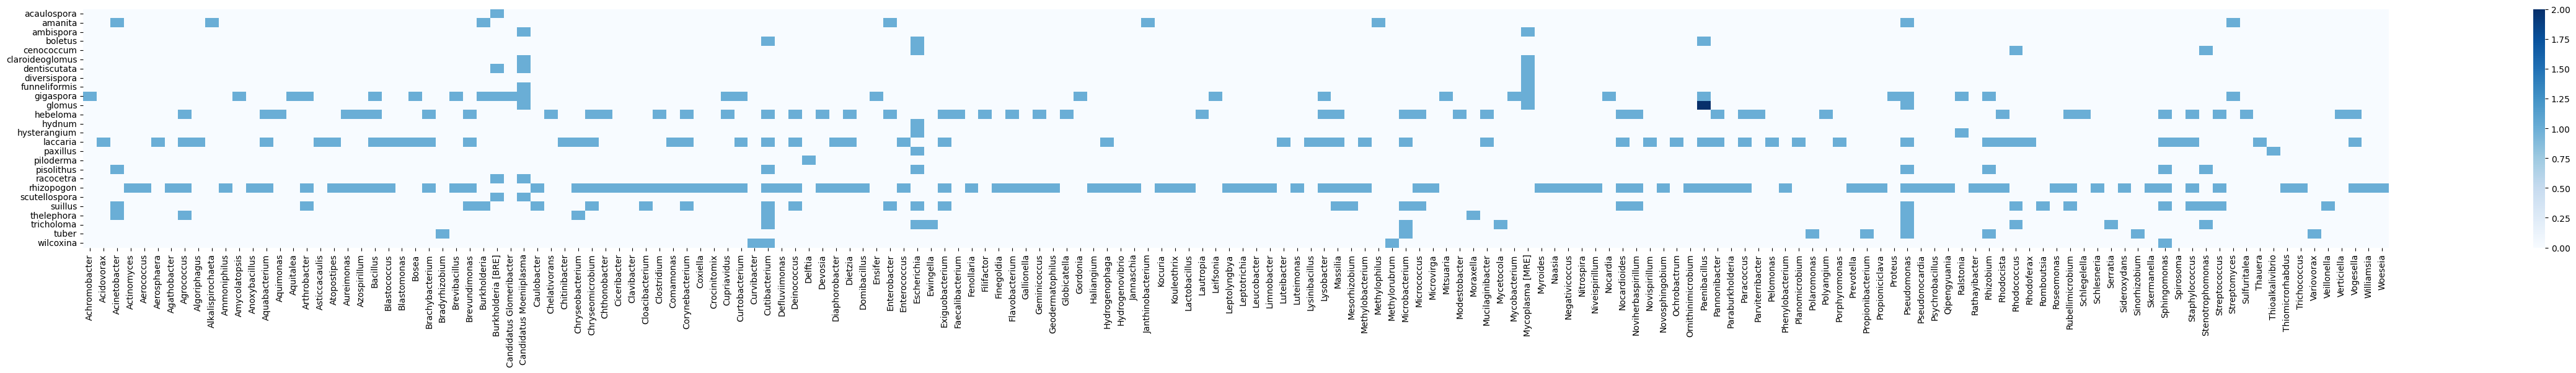

In [24]:
fig, ax = plt.subplots(figsize=(60,5))

heatmap_BFI_img = sns.heatmap(heatmap_BFI, cmap='Blues', xticklabels=Bacteria_cols, yticklabels=Fungi_rows, ax=ax)

plt.savefig("heatmap_BFI_img.png", dpi=300)

In [25]:
heatmap_BFI, Bacteria_cols, Fungi_rows = counts_heatmap(counts, add_headers=True)
if debug: 
    print(heatmap_BFI)
    print(Bacteria_cols)
    print(Fungi_rows)

In [26]:
heatmap_BFI_df = pd.DataFrame(heatmap_BFI)

if debug: print(heatmap_BFI_df)

heatmap_BFI_df.rename(columns={0 :'FungalGenus'}, inplace=True )

if debug: print(heatmap_BFI_df)

heatmap_BFI_df.to_csv('heatmap_BFI_df.csv', sep=',', index=True, encoding='utf-8')




In [27]:
#Prepare data for proper merge

BFI_df_alpha = heatmap_BFI_df.copy()
BFI_df_alpha.rename(columns={0 :'FungalGenus'}, inplace=True )
BFI_df_alpha['Sum'] = BFI_df_alpha.iloc[1:,1:].sum(axis=1)
BFI_df_alpha.loc['Total'] = BFI_df_alpha.iloc[1:,1:].sum()
BFI_df_alpha.fillna(0, inplace=True)
BFI_df_alpha.iloc[0,171] = BFI_df_alpha.iloc[1:27, 171].sum()


In [28]:
MycoDB_BFIBundle_Merged = pd.merge(BFI_df_alpha, MycoDB_ab_p_Merge, on = "FungalGenus")
print(MycoDB_BFIBundle_Merged)


#merged_df = pd.merge(df1, df2, on='key')

        FungalGenus              1           2              3            4  \
0                    Achromobacter  Acidovorax  Acinetobacter  Actinomyces   
1       acaulospora            0.0         0.0            0.0          0.0   
2           amanita            0.0         0.0            1.0          0.0   
3         ambispora            0.0         0.0            0.0          0.0   
4           boletus            0.0         0.0            0.0          0.0   
5        cenococcum            0.0         0.0            0.0          0.0   
6   claroideoglomus            0.0         0.0            0.0          0.0   
7      dentiscutata            0.0         0.0            0.0          0.0   
8      diversispora            0.0         0.0            0.0          0.0   
9     funneliformis            0.0         0.0            0.0          0.0   
10        gigaspora            1.0         0.0            0.0          0.0   
11           glomus            0.0         0.0            0.0   

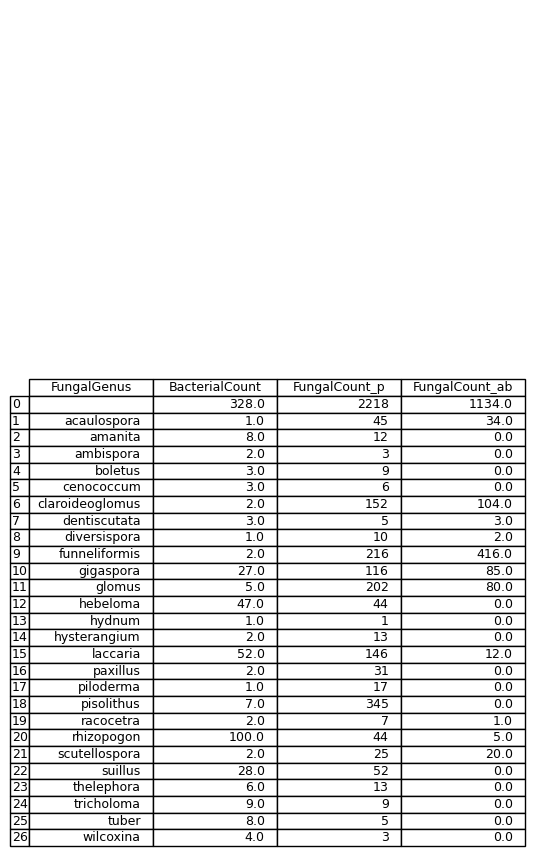

In [29]:
BFI_Myco_occur = MycoDB_BFIBundle_Merged.filter(['FungalGenus','Sum','FungalCount_p','FungalCount_ab'], axis=1)
if debug: print(BFI_Myco_occur)

BFI_Myco_occur.fillna(0, inplace=True)
BFI_Myco_occur.rename(columns = {'Sum' : 'BacterialCount'}, inplace=True)
if debug: print(BFI_Myco_occur)

ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  

table(ax,BFI_Myco_occur) 
plt.savefig('BFI_Myco.png')

In [30]:
#REMOVE OUTLIERS FROM p & ab AND RUN ANALYSIS

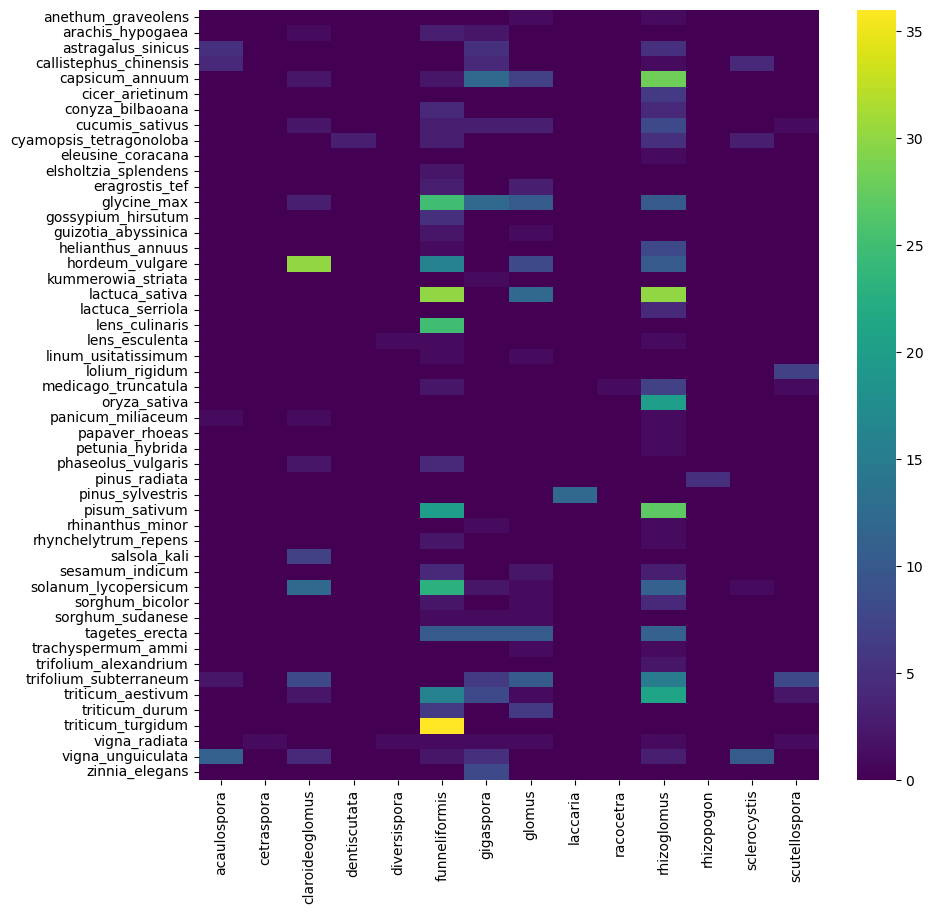

In [31]:
#Remove possible outlier species for analysis and generate material for heatmap

Mod_MycoDB_ab = filtered_rawdata_MycoDB_na_ab.copy()
Mod_MycoDB_ab = Mod_MycoDB_ab[Mod_MycoDB_ab['PlantSpecies'].str.contains('nicotiana_tabacum')==False]
Mod_MycoDB_ab = Mod_MycoDB_ab[Mod_MycoDB_ab['PlantSpecies'].str.contains('zea_mays')==False]
if debug:print(Mod_MycoDB_ab)

counts_ab, fungal_count_ab = correlate_counts(Mod_MycoDB_ab, "PlantSpecies", "FungalGenus")
if debug:
    print(counts_ab)
    print(fungal_count_ab)
    
heatmap_ab, fungi_cols_ab, plants_rows_ab = counts_heatmap(counts_ab)
heatmap_ab_df = pd.DataFrame(heatmap_ab)

if debug:
    pprint.pprint(heatmap_ab)
    print (heatmap_ab_df)

fig, ax = plt.subplots(figsize=(10,10))

heatmap_ab_img = sns.heatmap(heatmap_ab, cmap='viridis', xticklabels=fungi_cols_ab, yticklabels=plants_rows_ab, ax=ax)

plt.savefig("mod_heatmap_ab_img.png", dpi=300)

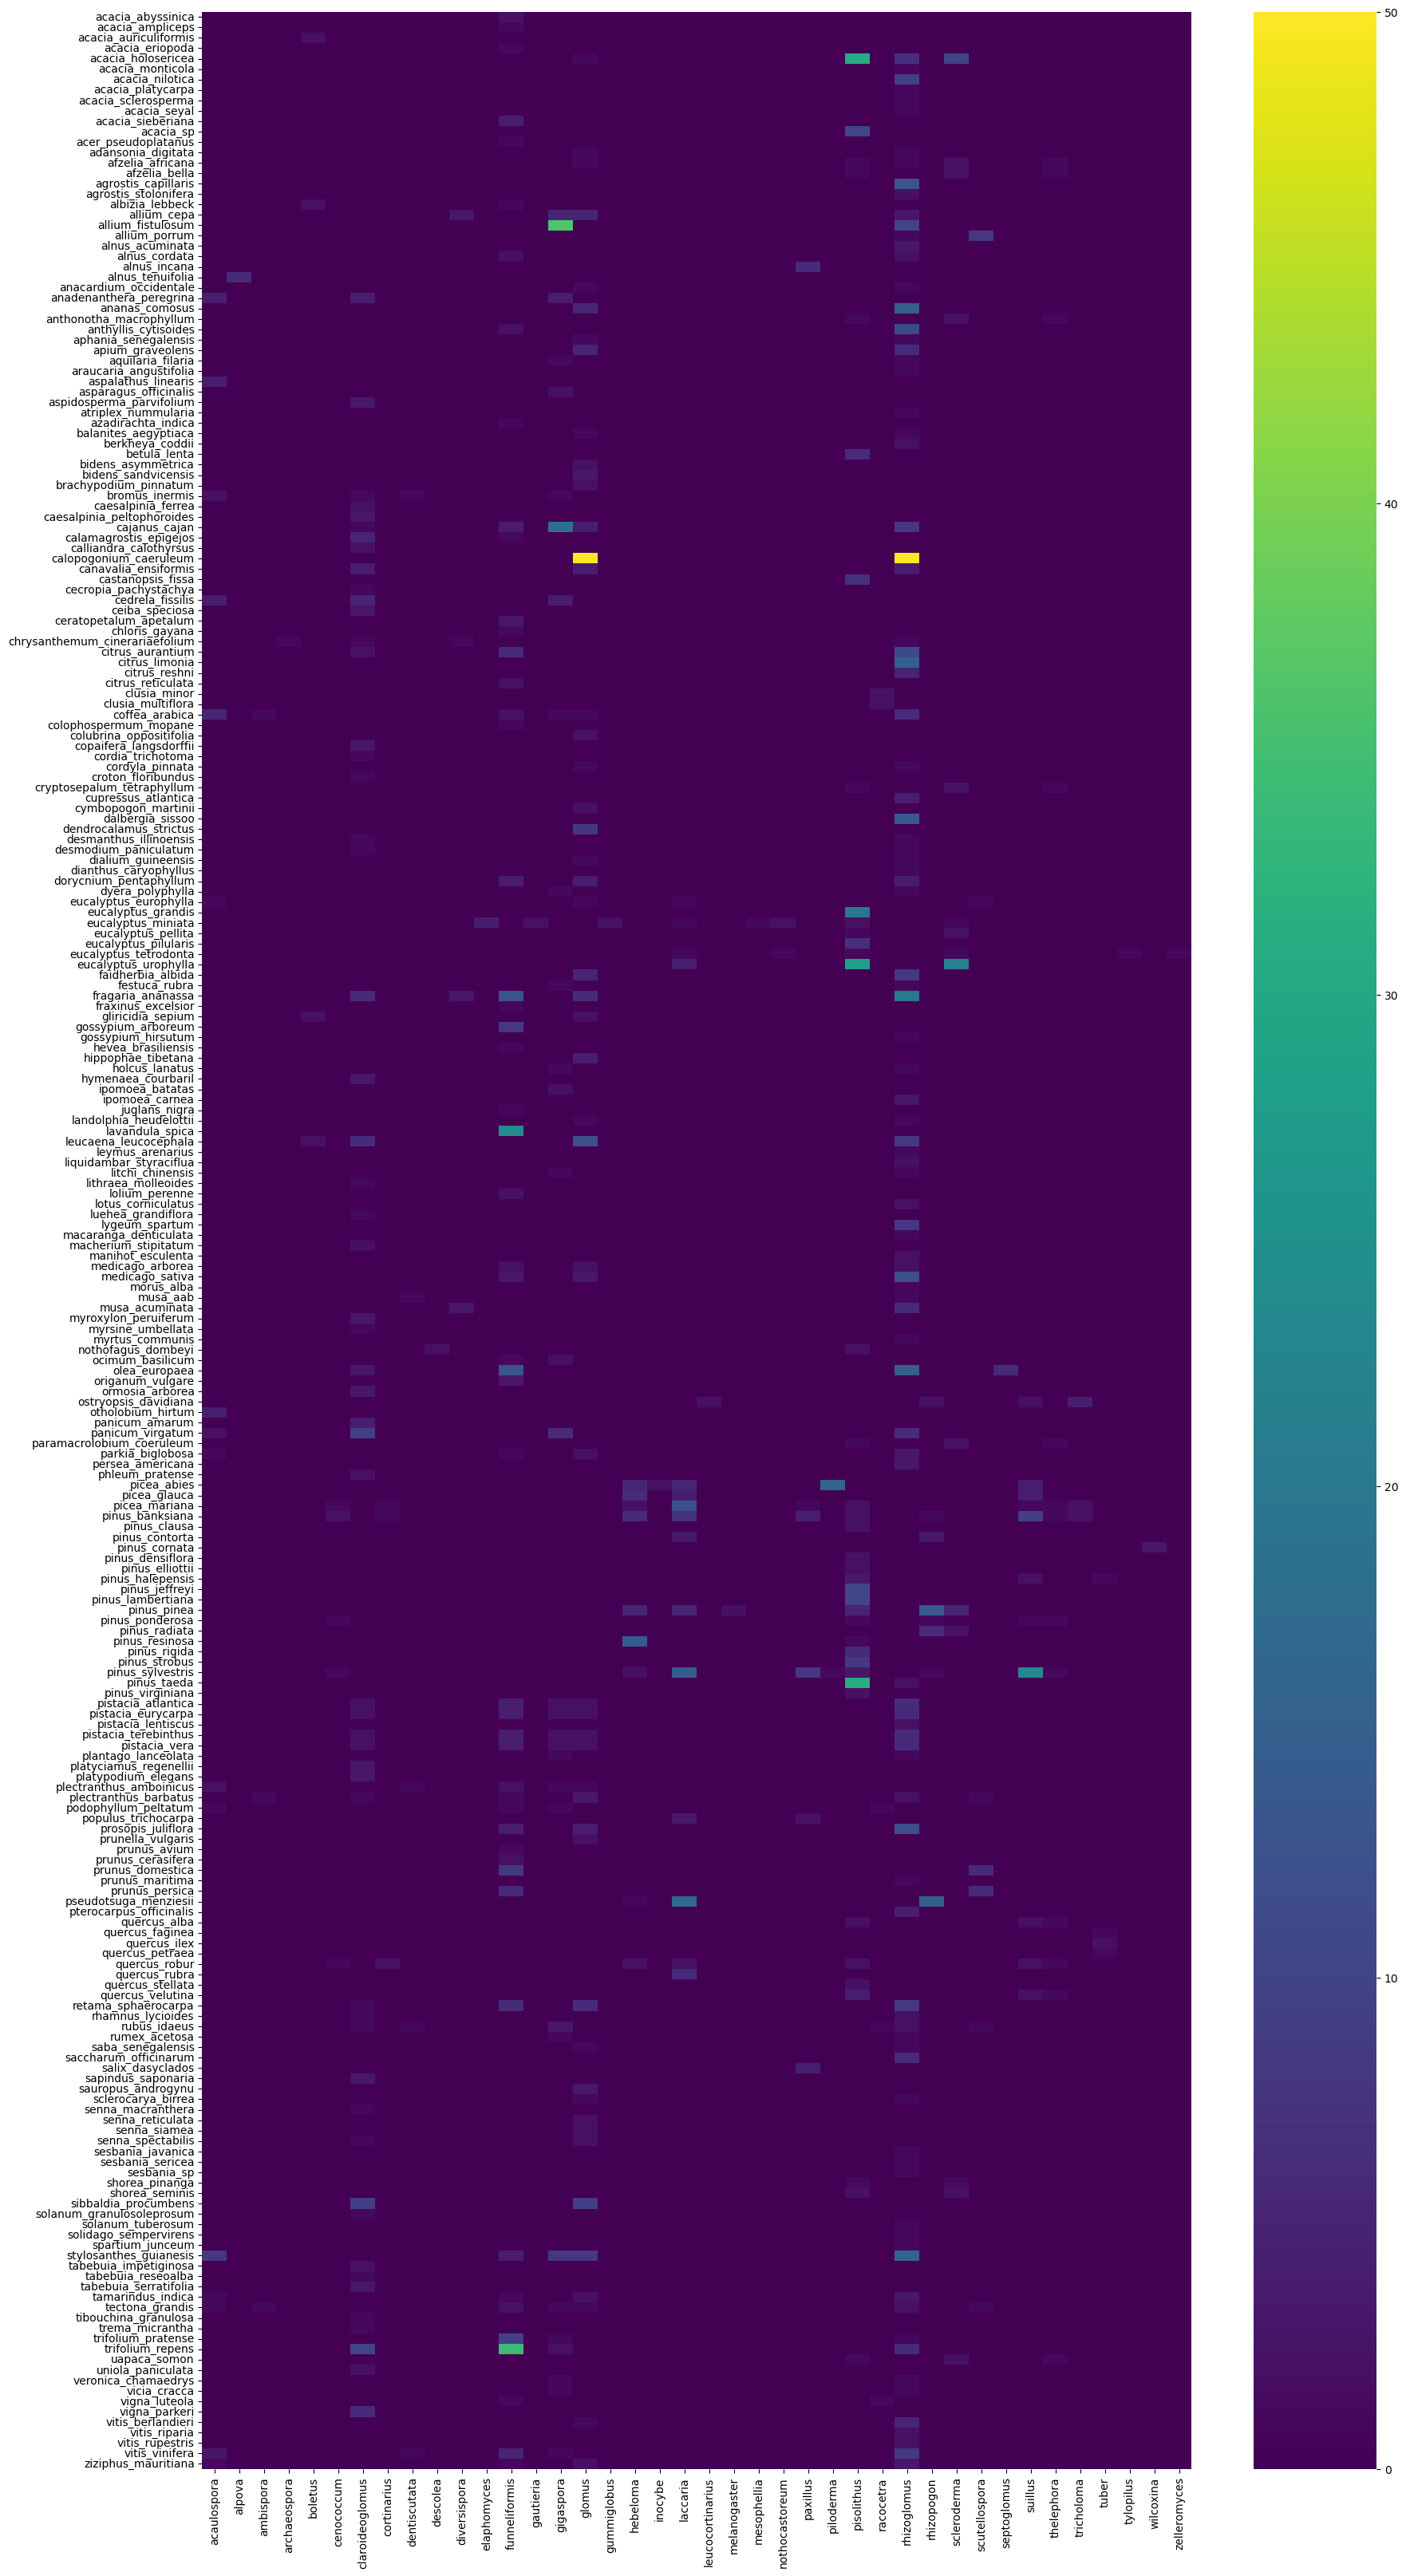

In [32]:
#Remove possible outlier species for analysis and generate material for heatmap

Mod_MycoDB_p = filtered_rawdata_MycoDB_na_p.copy()

Mod_MycoDB_p = Mod_MycoDB_p[Mod_MycoDB_p['PlantSpecies'].str.contains('pinus_pinaster')==False]
Mod_MycoDB_p = Mod_MycoDB_p[Mod_MycoDB_p['PlantSpecies'].str.contains('eucalyptus_globulus')==False]
Mod_MycoDB_p = Mod_MycoDB_p[Mod_MycoDB_p['PlantSpecies'].str.contains('eucalyptus_diversicolor')==False]
if debug:print(Mod_MycoDB_p)

counts_p, fungal_count_p = correlate_counts(Mod_MycoDB_p, "PlantSpecies", "FungalGenus")
if debug:
    print(counts_p)
    print(fungal_count_p)
    
heatmap_p, fungi_cols_p, plants_rows_p = counts_heatmap(counts_p)
heatmap_p_df = pd.DataFrame(heatmap_p)

if debug:
    pprint.pprint(heatmap_p)
    print (heatmap_p_df)

fig, ax = plt.subplots(figsize=(20,40))

heatmap_p_img = sns.heatmap(heatmap_p, cmap='viridis', xticklabels=fungi_cols_p, yticklabels=plants_rows_p, ax=ax)

plt.savefig("mod_heatmap_p_img.png", dpi=300)

In [33]:
#Prepare modified data for data metric tests

heatmap_ab_la = counts_heatmap(counts_ab, add_headers=True)
heatmap_ab_la_df = pd.DataFrame(heatmap_ab_la)
heatmap_ab_la_df.to_csv('heatmap_ab_la_df.csv', sep=',', index=True, encoding='utf-8')
heatmap_ab_mergedata = pd.read_csv('heatmap_ab_la_df.csv')
MycoDB_ab_merge = heatmap_ab_mergedata.copy()

if debug: print(heatmap_ab_mergedata)

heatmap_p_la = counts_heatmap(counts_p, add_headers=True)
heatmap_p_la_df = pd.DataFrame(heatmap_p_la)
heatmap_p_la_df.to_csv('heatmap_p_la_df.csv', sep=',', index=True, encoding='utf-8')
heatmap_p_mergedata = pd.read_csv('heatmap_p_la_df.csv')
MycoDB_p_merge = heatmap_p_mergedata.copy()

if debug: print(heatmap_p_mergedata)

In [34]:
#Unable to figure out how to make index column into real column without 
#loosing data, for merge. To and read csv to make it a column

fungal_count_ab_df = pd.DataFrame.from_dict(fungal_count_ab, orient = "index")
fungal_count_ab_df.to_csv('fungal_count_ab_df.csv', sep=',', index=True, encoding='utf-8')

fungal_count_p_df = pd.DataFrame.from_dict(fungal_count_p, orient = "index")
fungal_count_p_df.to_csv('fungal_count_p_df.csv', sep=',', index=True, encoding='utf-8')

In [35]:
#Rereading data and creating correct column headings

ab_fungal_mergedata = pd.read_csv('fungal_count_ab_df.csv')
ab_fungal_mergedata.rename( columns={'Unnamed: 0':'FungalGenus'}, inplace=True )
ab_fungal_mergedata.rename( columns={'0':'FungalCount_ab'}, inplace=True )

if debug: print(ab_fungal_mergedata)

p_fungal_mergedata = pd.read_csv('fungal_count_p_df.csv')
p_fungal_mergedata.rename( columns={'Unnamed: 0':'FungalGenus'}, inplace=True )
p_fungal_mergedata.rename( columns={'0':'FungalCount_p'}, inplace=True )

if debug: print(p_fungal_mergedata)

In [36]:
#Combined DF and remove NaN rows

ab_p_MycoDB_merged = p_fungal_mergedata.merge(ab_fungal_mergedata[
['FungalGenus', 'FungalCount_ab']], on = 'FungalGenus', how = 'left')
if debug: print(ab_p_MycoDB_merged)

#ab_p_MycoDB_merged_na = ab_p_MycoDB_merged.dropna()
ab_p_MycoDB_merged = ab_p_MycoDB_merged.drop([5])
#print (ab_p_MycoDB_merged_na)


In [37]:
#Creating a total for matching data in each column

ab_p_MycoDB_merged.loc['total']= ab_p_MycoDB_merged.sum()
ab_p_MycoDB_merged.loc[ab_p_MycoDB_merged.index[-1], 'FungalGenus'] = ''
#ab_p_MycoDB_merged['FungalCount_ab'] = ab_p_MycoDB_merged['FungalCount_ab'].fillna(0)


ab_p_MycoDB_Beta = ab_p_MycoDB_merged.copy()

ab_p_MycoDB_Alpha = ab_p_MycoDB_merged.copy()

MycoDB_ab_p_Merge = ab_p_MycoDB_merged.copy()

if debug: print(ab_p_MycoDB_merged)

In [38]:
#Shannon Index for Alpha Diversity within Life History Groups.

ab_p_MycoDB_Alpha.iloc[0:51,1] = ab_p_MycoDB_Alpha.iloc[0:51,1]/ab_p_MycoDB_Alpha.iloc[-1,1]
ab_p_MycoDB_Alpha.iloc[0:51,1] = -1*(ab_p_MycoDB_Alpha.iloc[0:51,1]*(np.log(ab_p_MycoDB_Alpha.iloc[0:51,1])))

ab_p_MycoDB_Alpha.iloc[0:51,2] = ab_p_MycoDB_Alpha.iloc[0:51,2]/ab_p_MycoDB_Alpha.iloc[-1,2]
ab_p_MycoDB_Alpha.iloc[0:51,2] = -1*(ab_p_MycoDB_Alpha.iloc[0:51,2]*(np.log(ab_p_MycoDB_Alpha.iloc[0:51,2])))

sum_row = ab_p_MycoDB_Alpha.iloc[0:51,1].sum()
ab_p_MycoDB_Alpha.iloc[-1,1] = sum_row
sum_row = ab_p_MycoDB_Alpha.iloc[0:51,2].sum()
ab_p_MycoDB_Alpha.iloc[-1,2] = sum_row

if debug: print(ab_p_MycoDB_Alpha)

In [39]:
#Percent change

change_mod = ab_p_MycoDB_Alpha.iloc[-1,2]/ab_p_MycoDB_Alpha.iloc[-1,1]
print(change_mod*100)

67.59258743100503


In [40]:
#Bray-Curtis Dissimilarity for a Beta Metric

for rows in ab_p_MycoDB_Beta.iterrows():
    ab_p_MycoDB_Beta['FungalCount_ab'].fillna(0, inplace=True)
    
for rows in ab_p_MycoDB_Beta.iterrows():
    ab_p_MycoDB_Beta['lesser'] = ab_p_MycoDB_Beta[['FungalCount_p', 'FungalCount_ab']].min(axis=1) 

    
ab_p_MycoDB_Beta.loc['total']= ab_p_MycoDB_Beta.iloc[0:51,1:4].sum()
ab_p_MycoDB_Beta.loc[ab_p_MycoDB_Beta.index[-1], 'FungalGenus'] = ''

print(ab_p_MycoDB_Beta)

Beta_mod = 1-(((2*ab_p_MycoDB_Beta.iloc[-1,3]))/((ab_p_MycoDB_Beta.iloc[-1,1]+ab_p_MycoDB_Beta.iloc[-1,2])))

print(Beta_mod)

            FungalGenus  FungalCount_p  FungalCount_ab  lesser
0       claroideoglomus            147            74.0    74.0
1             gigaspora            116            81.0    81.0
2           rhizoglomus            459           253.0   253.0
3         funneliformis            216           255.0   216.0
4                glomus            201            80.0    80.0
6           septoglomus              6             0.0     0.0
7           acaulospora             44            23.0    23.0
8            pisolithus            224             0.0     0.0
9            thelephora             13             0.0     0.0
10          scleroderma             58             0.0     0.0
11         diversispora             10             2.0     2.0
12        scutellospora             24            20.0    20.0
13              boletus              8             0.0     0.0
14            racocetra              7             1.0     1.0
15         dentiscutata              5             3.0 

In [41]:
MycoDB_BFIBundle_Merged = pd.merge(BFI_df_alpha, MycoDB_ab_p_Merge, on = "FungalGenus")
if debug: print(MycoDB_BFIBundle_Merged)


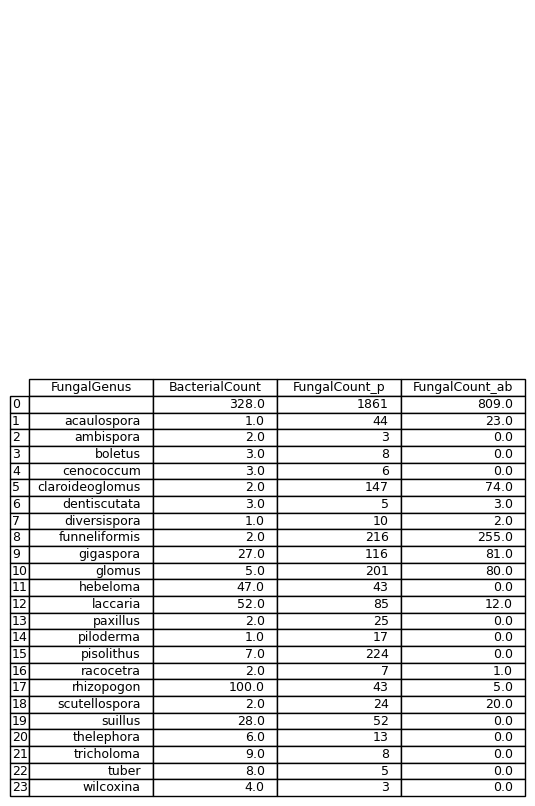

In [42]:
BFI_Myco_occur = MycoDB_BFIBundle_Merged.filter(['FungalGenus','Sum','FungalCount_p','FungalCount_ab'], axis=1)
if debug: print(BFI_Myco_occur)

BFI_Myco_occur.fillna(0, inplace=True)
BFI_Myco_occur.rename(columns = {'Sum' : 'BacterialCount'}, inplace=True)
if debug: print(BFI_Myco_occur)

ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  

table(ax,BFI_Myco_occur) 
plt.savefig('BFI_Myco_Mod.png')

In [43]:
print("Alpha diversity:", 'orginal is', change, 'and modifed is', change_mod)

Alpha diversity: orginal is 0.6047278283598496 and modifed is 0.6759258743100502


In [44]:
print("Alpha change is:", change_mod - change, 'or', (100*((change_mod-change)/change)), 'percent')

Alpha change is: 0.07119804595020063 or 11.773568638854417 percent


In [45]:
print("Beta diversity:", 'orginal is', Beta, 'and modifed is', Beta_mod)

Beta diversity: orginal is 0.4427207637231504 and modifed is 0.4086142322097378


In [46]:
print("Beta change is:", (Beta - Beta_mod), 'or', (100*((Beta_mod-Beta)/Beta)), 'percent')

Beta change is: 0.034106531513412586 or -7.703847279848988 percent
